# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

Loaded: pretrial_data.csv


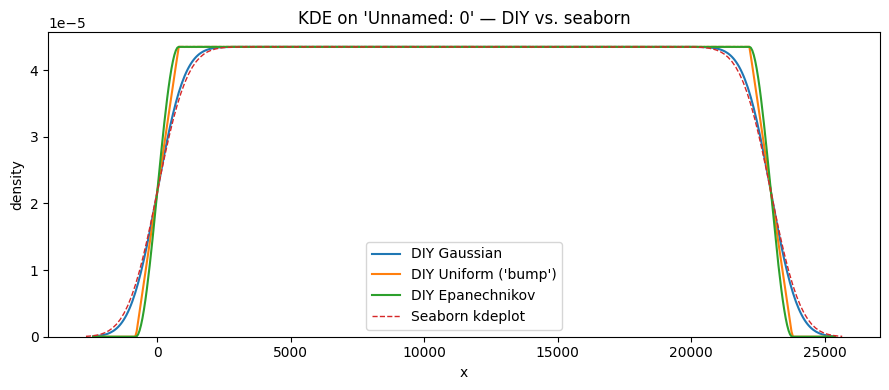

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try: #tries to instal scipy, if not revert back to numpy
    from scipy.spatial.distance import cdist
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False


def silverman_bandwidth(x: np.ndarray) -> float: #researched this online for KDEs
    """Silverman's rule: h = 0.9 * min(s, IQR/1.34) * n^(-1/5)."""
    n = x.size
    if n < 2:
        raise ValueError("Need at least two data points for Silverman bandwidth.")
    s = np.std(x, ddof=1)
    q75, q25 = np.percentile(x, [75, 25])
    sigma = min(s, (q75 - q25) / 1.34) if q75 > q25 else s
    return 0.9 * sigma * n ** (-1/5)


# Kernels: z = (x - xi)/h, inspired from the above instructions with formulas
def K_gaussian(z):        return np.exp(-0.5 * z**2) / np.sqrt(2*np.pi)
def K_uniform(z):         return 0.5 * (np.abs(z) <= 1).astype(float)
def K_epanechnikov(z):    return np.where(np.abs(z) <= 1, 0.75*(1 - z**2), 0.)

KERNELS = {
    "gaussian": K_gaussian, "normal": K_gaussian,
    "uniform": K_uniform,   "bump": K_uniform,
    "epanechnikov": K_epanechnikov, "epa": K_epanechnikov,
}


def kde1d(x, kernel="gaussian", bandwidth="silverman", #the KDE function required by the instructions
          n_points=512, cut=3.0, ax=None, label=None, color=None):
    """
    Simple from-scratch KDE:
      density(t) = (1/(n*h)) * sum_i K((t - x_i)/h)
    """
    # Accept Series or array, flatten, drop NaNs, input cleaning
    x = np.asarray(pd.Series(x).dropna().values, dtype=float)
    if x.size == 0:
        raise ValueError("No non-NaN values found in input.")

    # Bandwidth: Silverman by default, numeric override allowed
    h = silverman_bandwidth(x) if isinstance(bandwidth, str) and bandwidth.lower()=="silverman" else float(bandwidth)
    if not np.isfinite(h) or h <= 0: raise ValueError("bandwidth must be a positive float or 'silverman'.")

    # Evaluation grid
    grid = np.linspace(x.min()-cut*h, x.max()+cut*h, int(n_points))

    # Distances -> z = (grid - x)/h (SciPy cdist if present, else broadcasting)
    if HAVE_SCIPY:
        # if Scipy present use cdist like the suggestion said
        Z = cdist(grid.reshape(-1,1), x.reshape(-1,1)) / h
    else:
        Z = (grid[:, None] - x[None, :]) / h

    # Kernel choice (default gaussian); fully vectorized, no loops
    K = KERNELS.get(kernel.lower()) #implements the KDE formula
    if K is None:
        raise ValueError(f"Unknown kernel '{kernel}'. Choose from: {list(KERNELS.keys())}")
    dens = K(Z).mean(axis=1) / h

    # Plot with Matplotlib
    if ax is None: fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(grid, dens, label=label or f"{kernel}, h={h:.3g}", color=color)
    ax.set_xlabel("x"); ax.set_ylabel("density")
    return grid, dens, ax

if __name__ == "__main__": #had AI help on this because it was confusing
    # Try common locations
    for p in ["pretrial_data.csv", "/mnt/data/pretrial_data.csv"]:
        try:
            df = pd.read_csv(p); print(f"Loaded: {p}"); break
        except Exception:
            df = None
    if df is None: raise FileNotFoundError("Put 'pretrial_data.csv' next to this script.")

    # Pick first numeric column so this runs out-of-the-box
    col = df.select_dtypes(include=[np.number]).columns[0]
    x = df[col]

    fig, ax = plt.subplots(figsize=(9,4))
    kde1d(x, kernel="gaussian", bandwidth="silverman", ax=ax, label="DIY Gaussian")
    kde1d(x, kernel="uniform",  bandwidth="silverman", ax=ax, label="DIY Uniform ('bump')")
    kde1d(x, kernel="epanechnikov", bandwidth="silverman", ax=ax, label="DIY Epanechnikov")
    # Required comparison to seaborn's KDE (outside our function as instructed)
    sns.kdeplot(x=x, ax=ax, label="Seaborn kdeplot", linewidth=1, linestyle="--", fill=False)
    ax.set_title(f"KDE on '{col}' — DIY vs. seaborn")
    ax.legend()
    plt.tight_layout(); plt.show()

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

Loaded: college_completion.csv

[Q2.2] Dimensions (rows, cols): (3798, 63)
[Q2.2] Column names: ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vs

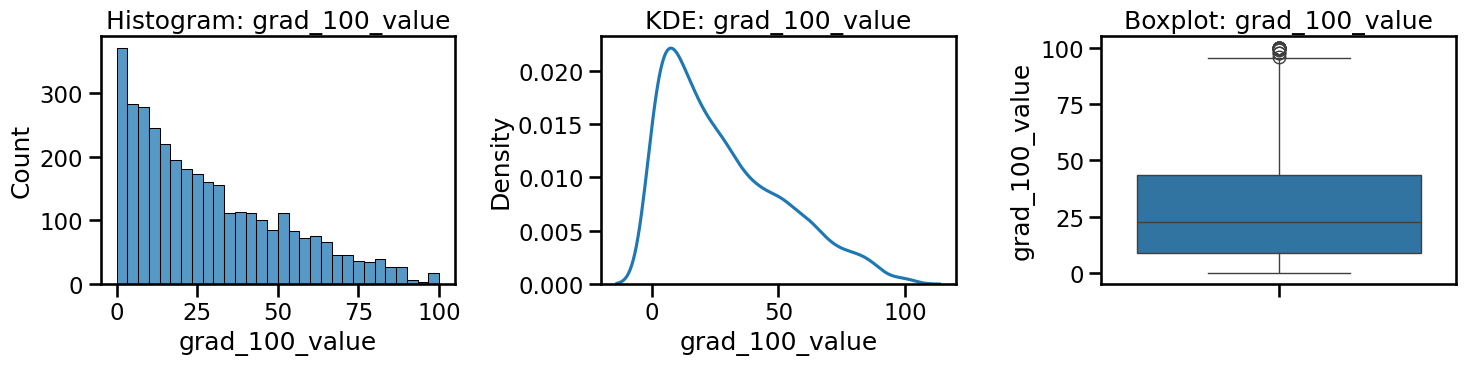


[Q2.4] Statistical description of grad_100_value:
                 count       mean       std  min  25%   50%    75%    max
grad_100_value  3467.0  28.364465  23.31273  0.0  9.0  22.5  43.65  100.0


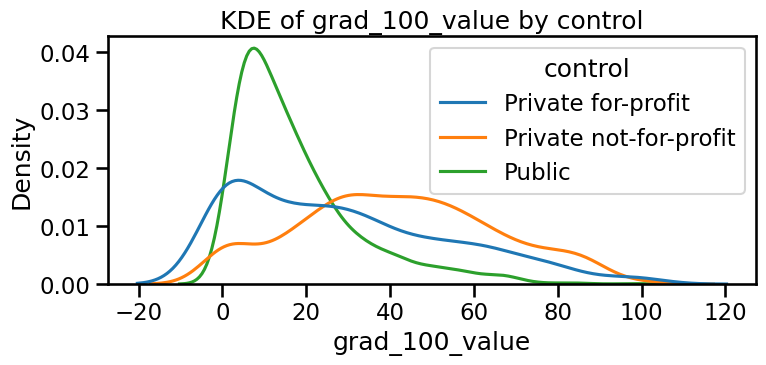

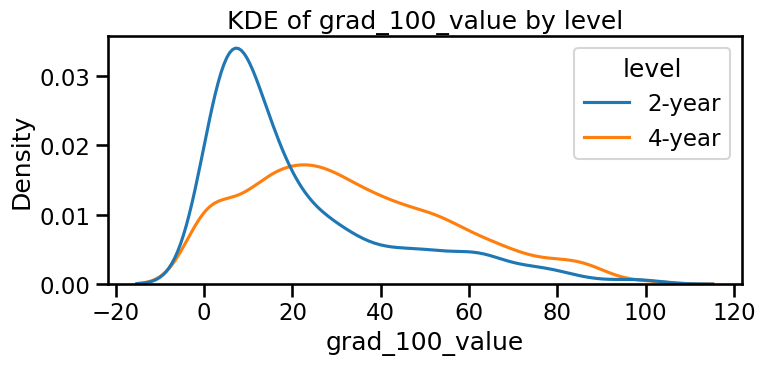


[Q2.5] Grouped descriptions of grad_100_value by control:
                         count    mean     std  min    25%   50%    75%    max
control                                                                       
Private for-profit       779.0  29.109  25.602  0.0   6.95  24.7  46.75  100.0
Private not-for-profit  1189.0  41.661  23.551  0.0  25.00  41.0  58.30  100.0
Public                  1499.0  17.431  14.729  0.0   6.90  13.2  23.25   97.8
Highest mean grad_100_value by control: Private not-for-profit => 41.661

[Q2.5] Grouped descriptions of grad_100_value by level:
         count    mean     std  min   25%   50%     75%    max
level                                                         
2-year  1455.0  21.636  21.646  0.0   6.0  13.0  30.600  100.0
4-year  2012.0  33.230  23.270  0.0  15.2  29.7  49.225  100.0
Highest mean grad_100_value by level: 4-year => 33.23


/tmp/ipython-input-1380713608.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_ctrl = df.groupby("control")["grad_100_value"].describe().round(3)
/tmp/ipython-input-1380713608.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_lvl = df.groupby("level")["grad_100_value"].describe().round(3)


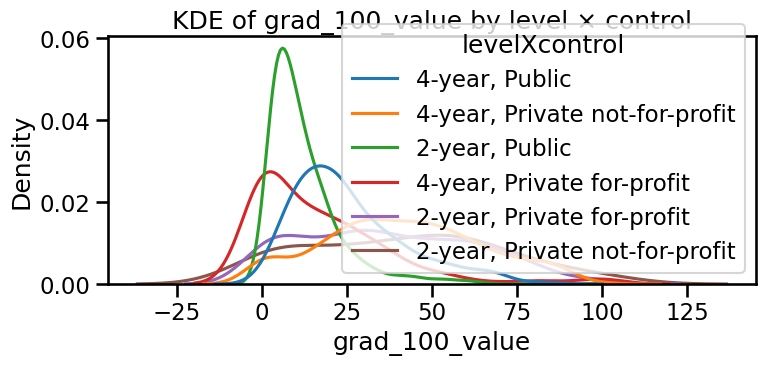


[Q2.6] Grouped descriptions of grad_100_value by level×control:
                                 count    mean     std  min     25%   50%  \
levelXcontrol                                                               
2-year, Private not-for-profit    68.0  41.913  28.348  0.0  16.225  44.4   
4-year, Private not-for-profit  1121.0  41.646  23.243  0.0  25.000  41.0   
2-year, Private for-profit       461.0  37.198  25.497  0.0  15.800  33.9   
4-year, Public                   573.0  25.561  16.404  0.0  13.600  21.8   
4-year, Private for-profit       318.0  17.383  20.789  0.0   0.000  12.5   
2-year, Public                   926.0  12.400  10.894  0.0   5.100   9.4   

                                   75%    max  
levelXcontrol                                  
2-year, Private not-for-profit  61.200  100.0  
4-year, Private not-for-profit  57.800  100.0  
2-year, Private for-profit      57.800  100.0  
4-year, Public                  33.800   86.3  
4-year, Private for-profit    

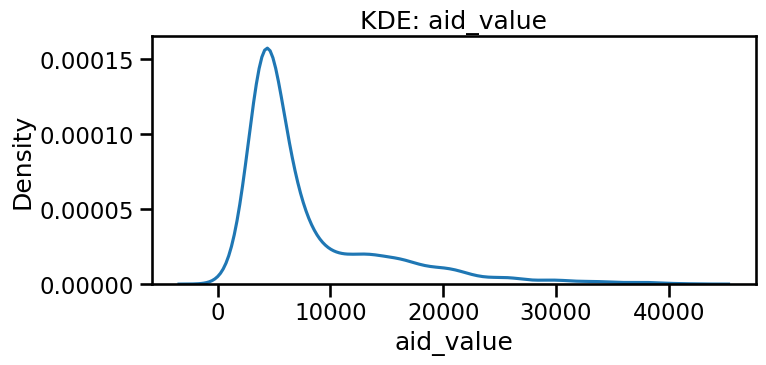

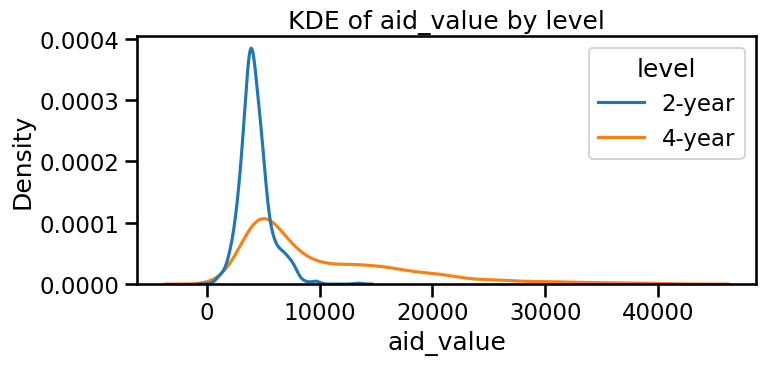

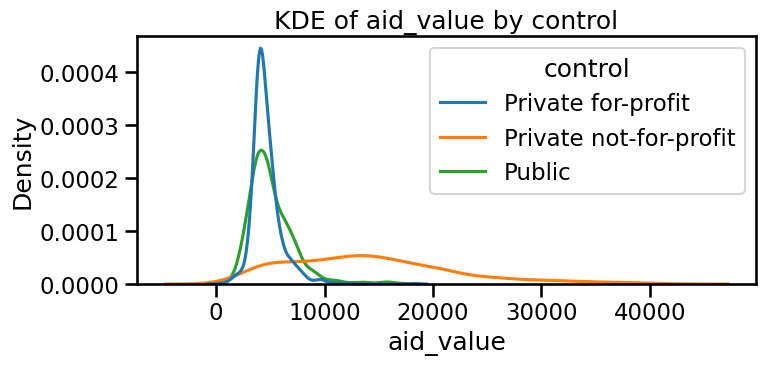


[Q2.7] Grouped descriptions of aid_value by level and control:
                                count       mean       std     min      25%  \
level  control                                                                
2-year Private for-profit       464.0   4559.681  1286.688   294.0  3818.75   
       Private not-for-profit    68.0   5128.059  2590.450   934.0  3650.00   
       Public                   926.0   4126.200  1260.271   881.0  3311.25   
4-year Private for-profit       527.0   4696.063  1489.410  1580.0  3885.50   
       Private not-for-profit  1180.0  14702.402  7649.775   902.0  9113.25   
       Public                   632.0   6514.071  2353.717  2232.0  4990.50   

                                   50%       75%      max  
level  control                                             
2-year Private for-profit       4286.5   5122.00   9727.0  
       Private not-for-profit   4516.5   6311.50  13654.0  
       Public                   3943.5   4762.00   9809.0  
4-y

/tmp/ipython-input-1380713608.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aid_desc = df.groupby(["level","control"])["aid_value"].describe().round(3)
/tmp/ipython-input-1380713608.py:123: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  print(df.pivot_table(index="level", columns="control", values="aid_value", aggfunc="mean").round(1))


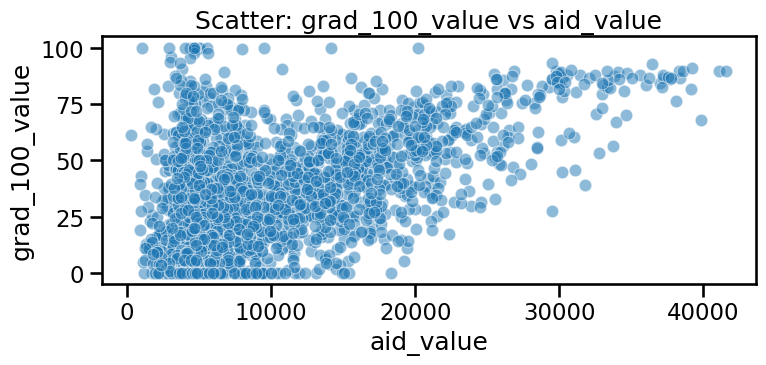

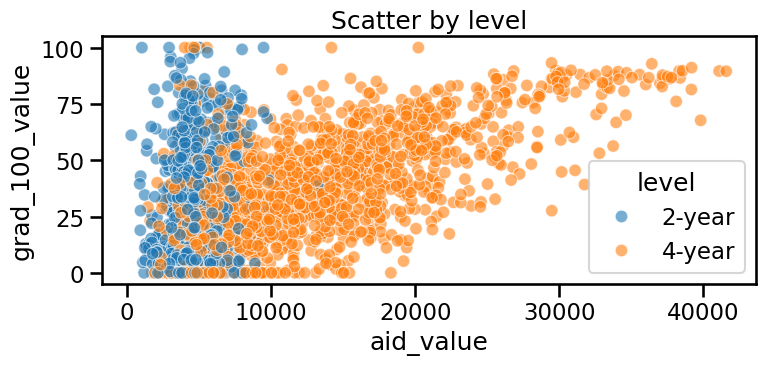

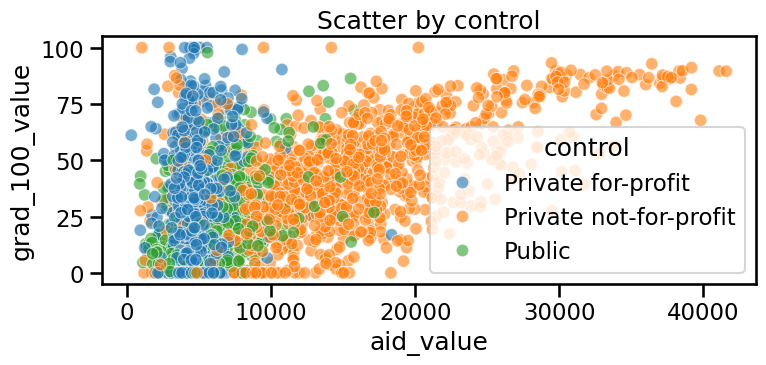


[Q2.8] Pearson correlation between aid_value and grad_100_value (overall): 0.576
[Q2.8] Correlation by level:
level
2-year    0.211
4-year    0.670
dtype: float64
[Q2.8] Correlation by control:
control
Private for-profit        0.188
Private not-for-profit    0.602
Public                    0.482
dtype: float64


/tmp/ipython-input-1380713608.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("level").apply(lambda d: pearson(d["aid_value"], d["grad_100_value"]).round(3)))
/tmp/ipython-input-1380713608.py:149: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df.groupby("level").apply(lambda d: pearson(d["aid_value"], d["grad_100_value"]).round(3)))
/tmp/ipython-input-1380713608.py:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p

In [3]:
import pandas as pd #import needed packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (8,4)

# 1) Load data (tries common class paths) AI help becuase for/try statements confuse me somewhat still
paths = ["./data/college_completion.csv", "data/college_completion.csv", "college_completion.csv", "/mnt/data/college_completion.csv"] #AI helped me with this section
df = None
for p in paths:
    try:
        df = pd.read_csv(p)
        print(f"Loaded: {p}")
        break
    except Exception:
        pass
if df is None:
    raise FileNotFoundError("Place 'college_completion.csv' in ./data/ or the working directory.")

# Ensure expected columns exist
required = ["level", "aid_value", "control", "grad_100_value"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected column(s): {missing}")

# Treat grouping vars as categories (helps plotting/groupby clarity)
df["level"]   = df["level"].astype("category")
df["control"] = df["control"].astype("category")

# 2) Dimensions, variables, head (prints)
print("\n[Q2.2] Dimensions (rows, cols):", df.shape)
print("[Q2.2] Column names:", list(df.columns))
print("[Q2.2] First five rows:")
print(df.head())

# 3) Cross-tabulate control x level and describe visible patterns
print("\n[Q2.3] Crosstab of control x level (counts):")
ct = pd.crosstab(df["control"], df["level"])
print(ct)

print("\n[Q2.3] Row proportions (each control sums to 1):")
row_prop = ct.div(ct.sum(axis=1), axis=0).round(3)
print(row_prop)

# Quick, data-driven one-liners describing the pattern:
print("\n[Q2.3] Pattern notes:")
print("  • Largest cell overall:", ct.stack().idxmax(), "with count", ct.values.max())
print("  • For each control, the most common level is:")
for ctrl, sub in ct.iterrows():
    print(f"    - {ctrl}: {sub.idxmax()} (count {sub.max()})")

# 4) grad_100_value: histogram, KDE, boxplot + describe
g = df["grad_100_value"].dropna()
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(g, bins=30, ax=axes[0])
axes[0].set_title("Histogram: grad_100_value")

sns.kdeplot(x=g, ax=axes[1])
axes[1].set_title("KDE: grad_100_value")

sns.boxplot(y=g, ax=axes[2])
axes[2].set_title("Boxplot: grad_100_value")
plt.tight_layout(); plt.show()

print("\n[Q2.4] Statistical description of grad_100_value:")
print(g.describe().to_frame().T)

# 5) Grouped KDEs for grad_100_value by control and by level; grouped .describe
fig, ax = plt.subplots()
sns.kdeplot(data=df, x="grad_100_value", hue="control", common_norm=False, ax=ax)
ax.set_title("KDE of grad_100_value by control"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data=df, x="grad_100_value", hue="level", common_norm=False, ax=ax)
ax.set_title("KDE of grad_100_value by level"); plt.tight_layout(); plt.show()

print("\n[Q2.5] Grouped descriptions of grad_100_value by control:")
desc_ctrl = df.groupby("control")["grad_100_value"].describe().round(3)
print(desc_ctrl)
print("Highest mean grad_100_value by control:", desc_ctrl["mean"].idxmax(), "=>", desc_ctrl["mean"].max())

print("\n[Q2.5] Grouped descriptions of grad_100_value by level:")
desc_lvl = df.groupby("level")["grad_100_value"].describe().round(3)
print(desc_lvl)
print("Highest mean grad_100_value by level:", desc_lvl["mean"].idxmax(), "=>", desc_lvl["mean"].max())

# 6) Interaction level x control + grouped KDE + best graduation rates among combos
df["levelXcontrol"] = df["level"].astype(str) + ", " + df["control"].astype(str)

fig, ax = plt.subplots()
sns.kdeplot(data=df, x="grad_100_value", hue="levelXcontrol", common_norm=False, ax=ax)
ax.set_title("KDE of grad_100_value by level × control"); plt.tight_layout(); plt.show()

print("\n[Q2.6] Grouped descriptions of grad_100_value by level×control:")
desc_both = df.groupby("levelXcontrol")["grad_100_value"].describe().round(3)
print(desc_both.sort_values("mean", ascending=False))
best_pair = desc_both["mean"].idxmax()
print("Best mean grad_100_value (level×control):", best_pair, "=>", desc_both.loc[best_pair, "mean"])

# 7) KDE of aid_value (overall + grouped) and grouped .describe by level & control
a = df["aid_value"].dropna()
fig, ax = plt.subplots()
sns.kdeplot(x=a, ax=ax)
ax.set_title("KDE: aid_value"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data=df, x="aid_value", hue="level", common_norm=False, ax=ax)
ax.set_title("KDE of aid_value by level"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data=df, x="aid_value", hue="control", common_norm=False, ax=ax)
ax.set_title("KDE of aid_value by control"); plt.tight_layout(); plt.show()

print("\n[Q2.7] Grouped descriptions of aid_value by level and control:")
aid_desc = df.groupby(["level","control"])["aid_value"].describe().round(3)
print(aid_desc)
print("\n[Q2.7] Mean aid_value pivot (higher values stand out):")
print(df.pivot_table(index="level", columns="control", values="aid_value", aggfunc="mean").round(1))

# 8) Scatter of grad_100_value vs aid_value; then colored by level and by control. AI also helped some in the section to code quicker
#    Also compute simple correlations overall and by groups to "describe what we see".
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="aid_value", y="grad_100_value", alpha=0.5, ax=ax)
ax.set_title("Scatter: grad_100_value vs aid_value"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
sns.scatterplot(data=df, x="aid_value", y="grad_100_value", hue="level", alpha=0.6, ax=ax)
ax.set_title("Scatter by level"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
sns.scatterplot(data=df, x="aid_value", y="grad_100_value", hue="control", alpha=0.6, ax=ax)
ax.set_title("Scatter by control"); plt.tight_layout(); plt.show()

# Correlations (overall and by groups) to back up the narrative
def pearson(x, y):
    x = pd.to_numeric(x, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")
    return x.corr(y)

print("\n[Q2.8] Pearson correlation between aid_value and grad_100_value (overall):",
      pearson(df["aid_value"], df["grad_100_value"]).round(3))

print("[Q2.8] Correlation by level:")
print(df.groupby("level").apply(lambda d: pearson(d["aid_value"], d["grad_100_value"]).round(3)))

print("[Q2.8] Correlation by control:")
print(df.groupby("control").apply(lambda d: pearson(d["aid_value"], d["grad_100_value"]).round(3)))


Responses to qualtiative questions (such as what do you see, describe relationships, etc.)

Q2.1: *no question
Q2.2: all needed information listed in code output
Q2.3: I noticed that many scools cluster around the low end, with a decreasing amount at the higher ends. The biggest amount of schools are 4 year private with public somewhat behind
Q2.4: *no question for describing
Q2.5: private non-profit 4 year have the best graduation rate on time followed by private for profit
Q2.6: highest is 4 year non-profit, lowest are 2 year public and 4-year private for-profit
Q2.7: 4 year non-profit drive the tail end of financial aid, this is most likely due to the fact that they are very expensive compared to other kinds of universties on average
Q2.8: Note that the needed scatterplots are above. Aid appears most strongly associated with higher graduation rates at 4-year institutions, especially Private not-for-profit schools; the relationship is moderate for Public and much weaker for Private for-profit and 2-year institutions.